### Import Statements

In [1]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectFromModel, SelectPercentile, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.feature_selection import ColumnSelector, SequentialFeatureSelector
import pandas as pd
import numpy as np
#from xgboost import XGBRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.tree import export_graphviz

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Quantile Cuts for Hour of Day to divide Hour of Days into 4 Main 6 Hour Categories

In [19]:
outs = data['HourOfDay'] 
data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)

In [20]:
data.dtypes

pickup_time                      object
num_pickups                     float64
num_passengers                  float64
temp                            float64
temp_min                        float64
temp_max                        float64
humidity                        float64
wind_speed                      float64
Passengers                      float64
Month                             int64
HourOfDay                      category
DayOfWeek                         int64
holiday                           int64
precip_in                       float64
Avg_Delay_Arriving              float64
Avg_Delay_Departing             float64
Cancelled_Arriving_Flights      float64
Cancelled_Departing_Flights     float64
clear                             int64
clouds                            int64
fog                               int64
rain                              int64
snow                              int64
thunderstorm                      int64
dtype: object

In [21]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Drop the Pickup Time and Number of Passengers

In [22]:
data.drop([
        "pickup_time",
        "num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [23]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [24]:
data.drop(['Avg_Delay_Departing'], axis=1, inplace=True)

### Last 2 hour Passengers (1 Hour Ago and 2 Hours Ago)

In [25]:
data['Prev_hour_Passengers'] = data['Passengers'].shift(1)
data['Prev_2hour_Passengers'] = data['Passengers'].shift(2)

In [26]:
data.Prev_hour_Passengers = data.Prev_hour_Passengers.fillna(method='bfill')
data.Prev_2hour_Passengers = data.Prev_2hour_Passengers.fillna(method='bfill')

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [27]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

### Converting Month and Day of Week to Categorical Data

In [28]:
data.Month = pd.Categorical(data.Month)
data.DayOfWeek = pd.Categorical(data.DayOfWeek)

In [29]:
data = pd.get_dummies(data)

In [30]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [31]:
data.dtypes

num_pickups                    float64
temp                           float64
humidity                       float64
wind_speed                     float64
Passengers                     float64
holiday                          int64
precip_in                      float64
Avg_Delay_Arriving             float64
Cancelled_Departing_Flights    float64
clear                            int64
clouds                           int64
fog                              int64
rain                             int64
snow                             int64
thunderstorm                     int64
Prev_hour_Passengers           float64
Prev_2hour_Passengers          float64
Month_1                          uint8
Month_2                          uint8
Month_3                          uint8
Month_4                          uint8
Month_5                          uint8
Month_6                          uint8
Month_7                          uint8
Month_8                          uint8
Month_9                  

## MODELS FOLLOW FROM HERE

In [32]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.15)

In [34]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

### VIsualizing mutual_info

In [35]:
categorical_cols = X_train.select_dtypes(include=['int64', 'uint8'])
continuous_cols = X_train.select_dtypes(exclude=['int64', 'uint8'])

In [36]:
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')

In [37]:
mi_continuous = mutual_info_regression(continuous_cols, y_train, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)


mi_categorical = mutual_info_regression(categorical_cols, y_train, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)

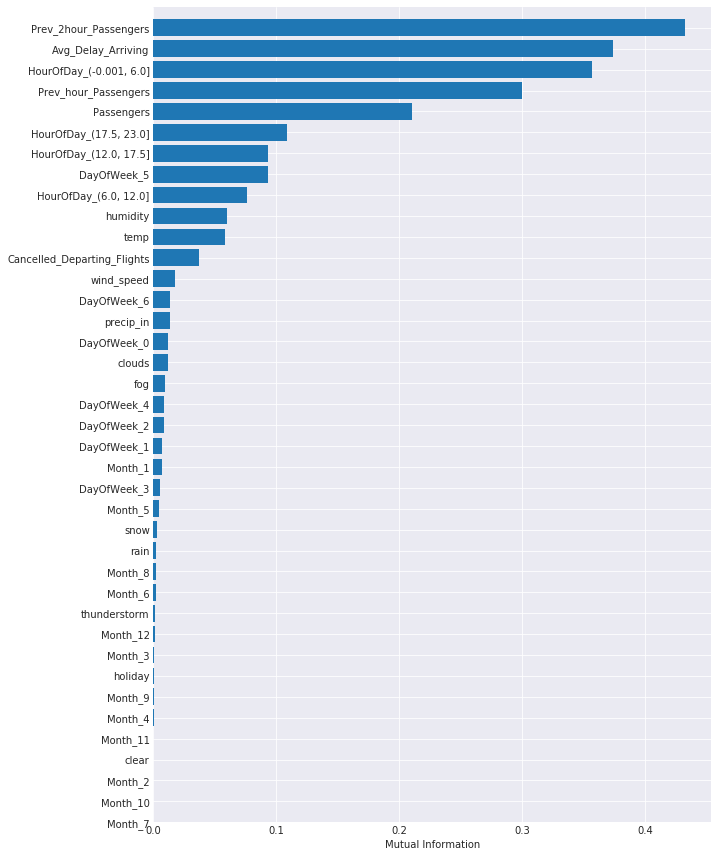

In [38]:
mutual_info = mi_continuous.tolist() + mi_categorical.tolist()
mutual_info_columns = continuous_cols.columns.tolist() + categorical_cols.columns.tolist()
plot_mutual_info(mutual_info, mutual_info_columns)

In [39]:
data.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


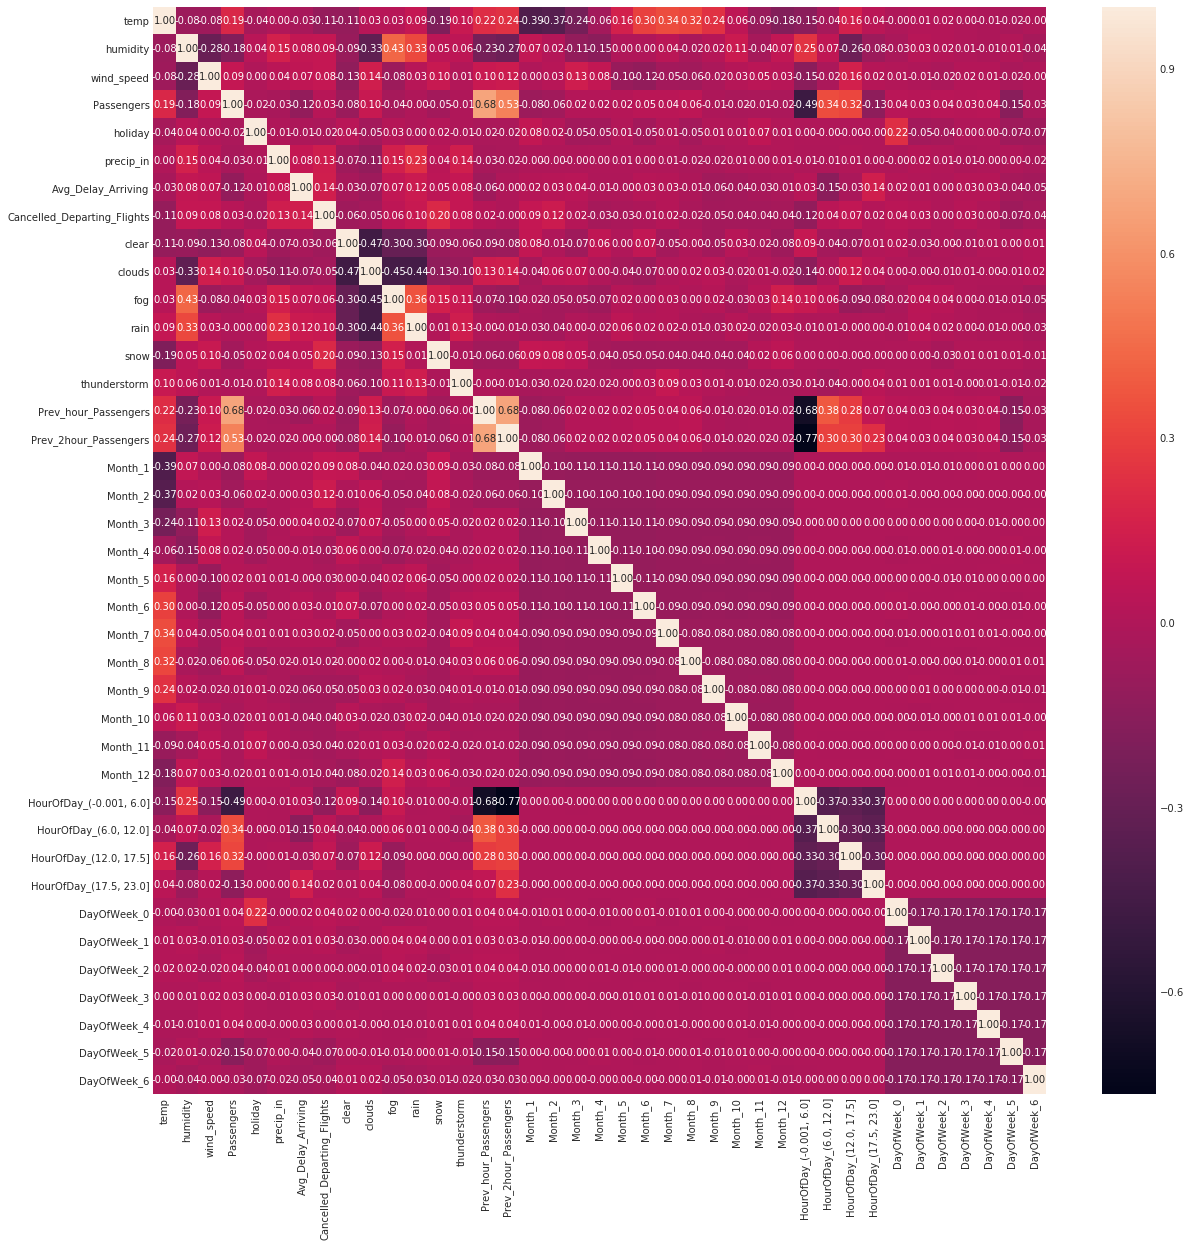

In [40]:
cor_scaler = StandardScaler()
data_scaled = cor_scaler.fit_transform(data)
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(data_scaled, columns=data.columns).corr(),
           annot=True, fmt=".2f")

### Some functions

In [41]:
def get_predictions(X_train, y_train, X_test, classifier):
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    return classifier.predict(X_test)

In [42]:
def plot_errors_hour(data, predictions, y_test):
    test_hours = data['HourOfDay'].loc[y_test.index]
    errors_df = pd.DataFrame({'HourOfDay' : test_hours, 'y_test' : y_test, 'predictions' : predictions})
    errors_df['error'] = errors_df.predictions - errors_df.y_test
    errors_df['error frac'] = errors_df.error / errors_df.y_test
    errors_df_hourly = errors_df.groupby('HourOfDay').agg({'error' : 'mean', 'error frac' : 'mean'})
    errors_df_hourly.plot(kind = 'bar')
    return errors_df_hourly

## Model Baseline : Linear Regression

In [46]:
LR_pipe = make_pipeline(StandardScaler(), LinearRegression())

In [47]:
LR_grid = GridSearchCV(LR_pipe, {}, cv=5, scoring='r2', verbose=1, n_jobs=-1)
LR_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [48]:
LR_grid.score(X_test, y_test)

0.73354126094947492

## KNeighbors Regressor

In [43]:
KNN_pipe = make_pipeline(StandardScaler(), 
                         SequentialFeatureSelector(estimator=RidgeCV(), k_features='best', scoring='r2'), 
                         PolynomialFeatures(interaction_only=True), 
                         VarianceThreshold(), 
                         KNeighborsRegressor(n_jobs=-1))

KNN_param_grid = {
    'polynomialfeatures__degree': [2],
    'kneighborsregressor__n_neighbors': [5, 15],
}

In [45]:
KNN_grid = GridSearchCV(KNN_pipe, KNN_param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
KNN_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.9min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 21.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sequentialfeatureselector', SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=No...kowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [2], 'kneighborsregressor__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [47]:
KNN_grid.best_score_

0.79356210744081346

In [49]:
KNN_grid.score(X_test, y_test)

0.79353706600310492

In [50]:
KNN_grid.best_params_

{'kneighborsregressor__n_neighbors': 15, 'polynomialfeatures__degree': 2}

In [52]:
joblib.dump(KNN_grid.best_estimator_, "gridSearch_Models/model_knn.pkl")

['gridSearch_Models/model_knn.pkl']

## Model_Ridge : Ridge Regression

In [56]:
select_lassocv = SelectFromModel(LassoCV(max_iter=1500), threshold="median")
ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge())
ridge_params = {'ridge__alpha' : [0.01, 0.1, 1.0, 10.0, 100.0, np.log(14)],
                'polynomialfeatures__degree' : [2]}

In [57]:
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [58]:
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfe

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   18.6s remaining:   18.6s


[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=  17.2s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=0.01, total=  18.0s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=10.0, total=  17.9s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=  17.3s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=   7.6s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   7.7s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   7.3s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   8.5s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=   8.8s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=10.0, total=  41.4s
[CV] .. polynomialfeatures__degree=2, ridge__alpha=0.01, total=  48.8s
[CV]  polynomialfeatures__degree=2, ridge__alpha=2.63905732962, total=  39.5s
[CV] . polynomialfeatures__degree=2, ridge__alpha=100.0, total=  56.8s
[CV] ... polynomialfeatures__degree=2, rid

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   58.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1500, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 2.6390573296152584], 'polynomialfeatures__degree': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [59]:
ridge_grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10.0}

In [60]:
ridge_grid.best_score_

0.79346448419176974

In [61]:
ridge_grid.score(X_test, y_test)

0.79440957296631032

In [62]:
joblib.dump(ridge_grid.best_estimator_, "gridSearch_Models/model_ridge.pkl")

['gridSearch_Models/model_ridge.pkl']

## Model_SVR : SVR

In [63]:
svr_pipe = make_pipeline(StandardScaler(), VarianceThreshold(), SVR())
svr_params = {'svr__kernel' : ['rbf', 'sigmoid'],
             'svr__C' : [0.01, 0.1, 1.0, 10.0, 100.0],
             'svr__epsilon' : [0.01, 0.05, 0.1, 0.2, 0.5]}
svr_grid = GridSearchCV(svr_pipe, svr_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [64]:
svr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.0

[CV] svr__C=0.1, svr__epsilon=0.05, svr__kernel=sigmoid ..............
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV] ... svr__C=0.1, svr__epsilon=0.01, svr__kernel=rbf, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV] ... svr__C=0.1, svr__epsilon=0.01, svr__kernel=rbf, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=sigmoid ...............
[CV] ... svr__C=0.1, svr__epsilon=0.01, svr__kernel=rbf, total= 1.4min
[C

[CV] svr__C=1.0, svr__epsilon=0.1, svr__kernel=sigmoid ...............
[CV] ... svr__C=1.0, svr__epsilon=0.01, svr__kernel=rbf, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.1, svr__kernel=sigmoid ...............
[CV]  svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.1, svr__kernel=sigmoid ...............
[CV]  svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=rbf ...................
[CV] ... svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=rbf ...................
[CV] ... svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=rbf ...................
[CV] ... svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=rbf ...................
[CV] ... svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf, total= 1.4min
[CV]

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 11.6min


[CV]  svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=sigmoid ...............
[CV]  svr__C=1.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.2, svr__kernel=sigmoid ...............
[CV]  svr__C=1.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.5, svr__kernel=rbf ...................
[CV]  svr__C=1.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.5, svr__kernel=rbf ...................
[CV]  svr__C=1.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.5, svr__kernel=rbf ...................
[CV]  svr__C=1.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=1.0, svr__epsilon=0.5, svr__kernel=rbf ...................
[CV] .... svr__C=1.0, svr__epsilon=0.1, svr__kernel=rbf, total= 1.3min
[CV] svr__C=1.0, svr__epsilon=0.5, svr__kernel=rbf ...................


[CV] ... svr__C=10.0, svr__epsilon=0.1, svr__kernel=rbf, total= 1.4min
[CV] svr__C=10.0, svr__epsilon=0.5, svr__kernel=sigmoid ..............
[CV] ... svr__C=10.0, svr__epsilon=0.1, svr__kernel=rbf, total= 1.4min
[CV] svr__C=10.0, svr__epsilon=0.5, svr__kernel=sigmoid ..............
[CV]  svr__C=10.0, svr__epsilon=0.05, svr__kernel=sigmoid, total= 1.5min
[CV] svr__C=10.0, svr__epsilon=0.5, svr__kernel=sigmoid ..............
[CV] ... svr__C=10.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.4min
[CV] svr__C=10.0, svr__epsilon=0.5, svr__kernel=sigmoid ..............
[CV] ... svr__C=10.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.4min
[CV] svr__C=100.0, svr__epsilon=0.01, svr__kernel=rbf ................
[CV] ... svr__C=10.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.4min
[CV] svr__C=100.0, svr__epsilon=0.01, svr__kernel=rbf ................
[CV] ... svr__C=10.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.4min
[CV] svr__C=100.0, svr__epsilon=0.01, svr__kernel=rbf ................
[CV]

[CV] .. svr__C=100.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.6min
[CV] .. svr__C=100.0, svr__epsilon=0.2, svr__kernel=rbf, total= 1.6min
[CV]  svr__C=100.0, svr__epsilon=0.2, svr__kernel=sigmoid, total= 1.7min
[CV]  svr__C=100.0, svr__epsilon=0.2, svr__kernel=sigmoid, total= 1.7min
[CV]  svr__C=100.0, svr__epsilon=0.2, svr__kernel=sigmoid, total= 1.7min
[CV]  svr__C=100.0, svr__epsilon=0.2, svr__kernel=sigmoid, total= 1.7min
[CV]  svr__C=100.0, svr__epsilon=0.2, svr__kernel=sigmoid, total= 1.8min
[CV] .. svr__C=100.0, svr__epsilon=0.5, svr__kernel=rbf, total= 1.3min
[CV] .. svr__C=100.0, svr__epsilon=0.5, svr__kernel=rbf, total= 1.3min
[CV] .. svr__C=100.0, svr__epsilon=0.5, svr__kernel=rbf, total= 1.3min
[CV] .. svr__C=100.0, svr__epsilon=0.5, svr__kernel=rbf, total= 1.3min
[CV] .. svr__C=100.0, svr__epsilon=0.5, svr__kernel=rbf, total= 1.3min
[CV]  svr__C=100.0, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV]  svr__C=100.0, svr__epsilon=0.5, svr__kernel=sigmoid, total=

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 25.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'svr__kernel': ['rbf', 'sigmoid'], 'svr__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [65]:
svr_grid.best_score_

0.84313775859448981

In [66]:
svr_grid.best_params_

{'svr__C': 100.0, 'svr__epsilon': 0.5, 'svr__kernel': 'rbf'}

In [67]:
svr_grid.score(X_test, y_test)

0.84527013537248286

In [68]:
joblib.dump(svr_grid.best_estimator_, "gridSearch_Models/model_svr.pkl")

['gridSearch_Models/model_svr.pkl']

### Random Forest

In [71]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [50, 100, 200], 
             'randomforestregressor__max_features' : ["auto", "sqrt", "log2"],
             'randomforestregressor__max_depth' : [5, 9, 11, 15, 17, 21],
#              'randomforestregressor__criterion' : ['mae', 'mse'],
             'randomforestregressor__warm_start' : [True, False]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [72]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50,

[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   2.2s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   4.6s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__war

[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   9.3s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, t

[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   1.2s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   1.3s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   2.5s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomfor

[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=   3.1s
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=   2.9s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor

[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=  10.5s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=  11.8s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   30.6s


[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.6s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.6s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.6s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomfore

[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   5.9s
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  18.4s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   6.1s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomfore

[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   1.3s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   1.4s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   1.4s
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, random

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   6.8s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   6.4s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   7.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfo

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.3s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.5s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.8s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, ran

[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  23.0s
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_st

[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   3.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   4.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   4.5s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, rand

[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   5.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   6.0s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=  17.9s
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, random

[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   6.8s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   6.7s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor_

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  1.9min


[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   3.5s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   3.4s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor_

[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.1s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.0s
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   3.1s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, random

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=  10.5s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=  10.7s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor_

[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   5.7s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   7.1s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   6.9s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, rand

[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  10.4s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  34.0s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  33.9s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, 

[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   3.3s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   3.9s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, total=   6.5s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, ran

[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   6.7s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, total=   7.5s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=  23.5s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomfo

[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, total=   8.9s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   8.7s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=False, total=   8.8s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, random

[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   3.2s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False, total=  12.3s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=False 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=False, total=   2.7s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=200, ran

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [50, 100, 200], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [5, 9, 11, 15, 17, 21], 'randomforestregressor__warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [73]:
rf_grid.best_score_

0.85750384614041009

In [74]:
rf_grid.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__warm_start': False}

In [75]:
rf_grid.score(X_test, y_test)

0.86015362177236665

In [76]:
joblib.dump(rf_grid.best_estimator_, "gridSearch_Models/model_rf.pkl")

['gridSearch_Models/model_rf.pkl']

### Gradient Boosting Regressor

In [80]:
gbt_pipe = make_pipeline(GradientBoostingRegressor(random_state=0, learning_rate=0.1))
gbt_params = {'gradientboostingregressor__n_estimators' : [50, 100, 200, 250],
              'gradientboostingregressor__max_features' : ["auto", "sqrt", "log2"],
              'gradientboostingregressor__max_depth' : [3, 5, 10, 15],
              'gradientboostingregressor__warm_start' : [False, True],
             }

gbt_grid = GridSearchCV(gbt_pipe, gbt_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [81]:
gbt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_de

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   4.6s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   4.8s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregre

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   1.2s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   1.2s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregres

[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   2.3s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=   2.2s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregress

[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.6s
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.7s
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   0.6s
[CV] gradientboostingregressor__max_depth=3, gradientboo

[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  12.3s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  12.2s
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   1.9s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientb

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   19.3s


[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=   2.4s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=3, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=   2.5s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   7.5s
[CV] gradientboostingregressor__max_depth=5, gradient

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.5s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.5s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.5s
[CV] gradientboostingregressor__max_depth=5, gradientboo

[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=  24.7s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=   5.2s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregress

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=   1.3s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   1.3s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=   1.3s
[CV] gradientboostingregressor__max_depth=5, gradientboosti

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.4s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.4s
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=   2.4s
[CV] gradientboostingregressor__max_depth=5, gradi

[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  30.3s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  30.3s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=   5.5s
[CV] gradientboostingregressor__max_depth=10, grad

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total= 1.3min
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total= 1.3min
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total= 1.3min
[CV] gradientboostingregressor__max_depth=10, g

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=  17.6s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total=  18.3s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total= 2.3min
[CV] gradientboostingregressor__max_depth=10, g

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 2.3min
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 2.4min
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total=  35.6s
[CV] gradientboostingregressor__max_depth=10, grad

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=  42.4s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=  43.9s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.8min


[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  42.2s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False, total=  43.1s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total=  43.3s
[CV] gradientboostingregressor__max_depth=10, g

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=  30.1s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=  30.8s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total=  30.1s
[CV] gradientboostingregressor__max_depth=15, gr

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total= 3.4min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total= 3.5min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total= 3.4min
[CV] gradientboostingregressor__max_depth=15, gradi

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, total=  45.6s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=  45.7s
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=  45.3s
[CV] gradientboostingregressor__max_depth=15, gradient

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 8.3min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 8.5min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, total= 2.6min
[CV] gradientboostingregressor__max_depth=15, g

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 2.6min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=True, total= 2.6min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=True, total=  40.6s
[CV] gradientboostingregressor__max_depth=15, gra

[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, total= 1.2min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=True, total= 1.2min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=log2, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True 
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=250, gradientboostingregressor__warm_start=True, total= 3.3min
[CV] gradientboostingregressor__max_depth=15, gr

[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 23.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min...ors=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gradientboostingregressor__n_estimators': [50, 100, 200, 250], 'gradientboostingregressor__max_features': ['auto', 'sqrt', 'log2'], 'gradientboostingregressor__max_depth': [3, 5, 10, 15], 'gradientboostingregressor__warm_start': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [82]:
gbt_grid.best_params_

{'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__max_features': 'log2',
 'gradientboostingregressor__n_estimators': 250,
 'gradientboostingregressor__warm_start': False}

In [83]:
gbt_grid.best_score_

0.86451058632487743

In [84]:
gbt_grid.score(X_test, y_test)

0.86677432107690033

In [85]:
joblib.dump(gbt_grid.best_estimator_, "gridSearch_Models/model_gbt.pkl")

['gridSearch_Models/model_gbt.pkl']

## XGBoost Regressor

In [86]:
n_estimators = [50, 100, 200, 250]
max_depth = [3, 6, 8]
learning_rate = [0.1, 0.3]
subsample = [1.0]
colsample_bytree = [0.7]
colsample_bylevel = [0.6]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
param_grid = dict(xgbregressor__n_estimators=n_estimators, 
                  xgbregressor__max_depth=max_depth, 
                  xgbregressor__learning_rate=learning_rate, 
                  xgbregressor__subsample=subsample, 
                  xgbregressor__colsample_bytree=colsample_bytree, 
                  xgbregressor__colsample_bylevel=colsample_bylevel,
                  xgbregressor__gamma=gamma
                 )
xgb_pipe = make_pipeline(StandardScaler(), XGBRegressor())
xgb_grid = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=2)

In [87]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregres

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.6s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.1s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=3, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7,

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, total=   0.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   1.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=8, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0, total=   0.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=3, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   0.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__n_estimators=250, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, total=   1.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.3, xgbregressor__max_depth=8, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 12.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgbregressor__n_estimators': [50, 100, 200, 250], 'xgbregressor__max_depth': [3, 6, 8], 'xgbregressor__learning_rate': [0.1, 0.3], 'xgbregressor__subsample': [1.0], 'xgbregressor__colsample_bytree': [0.7], 'xgbregressor__colsample_bylevel': [0.6], 'xgbregressor__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verb

In [88]:
xgb_grid.best_score_

0.8650022839804854

In [89]:
xgb_grid.best_params_

{'xgbregressor__colsample_bylevel': 0.6,
 'xgbregressor__colsample_bytree': 0.7,
 'xgbregressor__gamma': 0.5,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 250,
 'xgbregressor__subsample': 1.0}

In [90]:
xgb_grid.score(X_test, y_test)

0.86667016857504442

In [92]:
joblib.dump(xgb_grid.best_estimator_, "gridSearch_Models/model_xgb.pkl")

['gridSearch_Models/model_xgb.pkl']

### MLXTEND

In [35]:
from mlxtend.regressor import StackingCVRegressor

In [36]:
select_lassocv = SelectFromModel(LassoCV(max_iter=1500), threshold="median")

rf_mlxtend = RandomForestRegressor(max_depth=21, 
                                   max_features='sqrt', 
                                   n_estimators=200, 
                                   warm_start=False)

ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge(alpha=10.0))

gbt_mlxtend = GradientBoostingRegressor(max_depth=10, 
                                        max_features='log2', 
                                        n_estimators=250, warm_start=False)

xgb_mlxtend = make_pipeline(StandardScaler(), XGBRegressor(colsample_bylevel=0.6,
                                                          colsample_bytree=0.7,
                                                          gamma=0.5,
                                                          learning_rate=0.1,
                                                          max_depth=8,
                                                          n_estimators=250,
                                                          subsample=1.0))

RANDOM_SEED = 10

### Stacking Regressor 1

In [46]:
np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors=(rf_mlxtend, gbt_mlxtend, xgb_mlxtend), meta_regressor=ridge_pipe)

grid_stack1 = GridSearchCV(
    estimator=stack, 
    param_grid={}, 
    cv=5,
    verbose=3, 
    scoring="r2", 
    refit=True
)


In [48]:
# grid_stack1.fit(X_train.values, y_train.values)

In [50]:
# load the model from disk
loaded_model = joblib.load("gridSearch_Models/model_stack_rfgbtxgb_mrcv.pkl")
result = loaded_model.score(X_test, y_test)
print(result)

0.871891424495


### Stacking Regressor 2

In [51]:
np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors=(rf_mlxtend, gbt_mlxtend, xgb_mlxtend), meta_regressor=LassoCV(max_iter=2000))

grid_stack1 = GridSearchCV(
    estimator=stack, 
    param_grid={}, 
    cv=5,
    verbose=3, 
    scoring="r2", 
    refit=True
)

In [ ]:
# grid_stack1.fit(X_train.values, y_train.values)

In [52]:
# load the model from disk
loaded_model = joblib.load("gridSearch_Models/model_stack_rfgbtxgb_mlcv.pkl")
result = loaded_model.score(X_test, y_test)
print(result)

0.871892796946


In [53]:
loaded_model

StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
          regressors=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimato...near', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0))])),
          shuffle=True, use_features_in_secondary=False)

In [54]:
loaded_model.meta_regr_.coef_

array([ 0.12174289,  0.44023832,  0.45155576])

In [55]:
loaded_preds = loaded_model.predict(X_test)

In [58]:
data.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [81]:
results = pd.DataFrame({'Hour': outs[y_test.index], 'Predictions': loaded_preds, 'Actual': y_test})

In [82]:
results_grouped = results.groupby('Hour').mean()
results_grouped

,Actual,Predictions
Hour,,
0,258.390476,213.398115
1,59.331551,59.333978
2,13.411765,18.126812
3,4.921875,10.792704
4,7.189944,7.308786
5,13.640212,10.163300
6,28.868132,26.459847
7,190.661082,287.870738
8,326.583732,408.426192


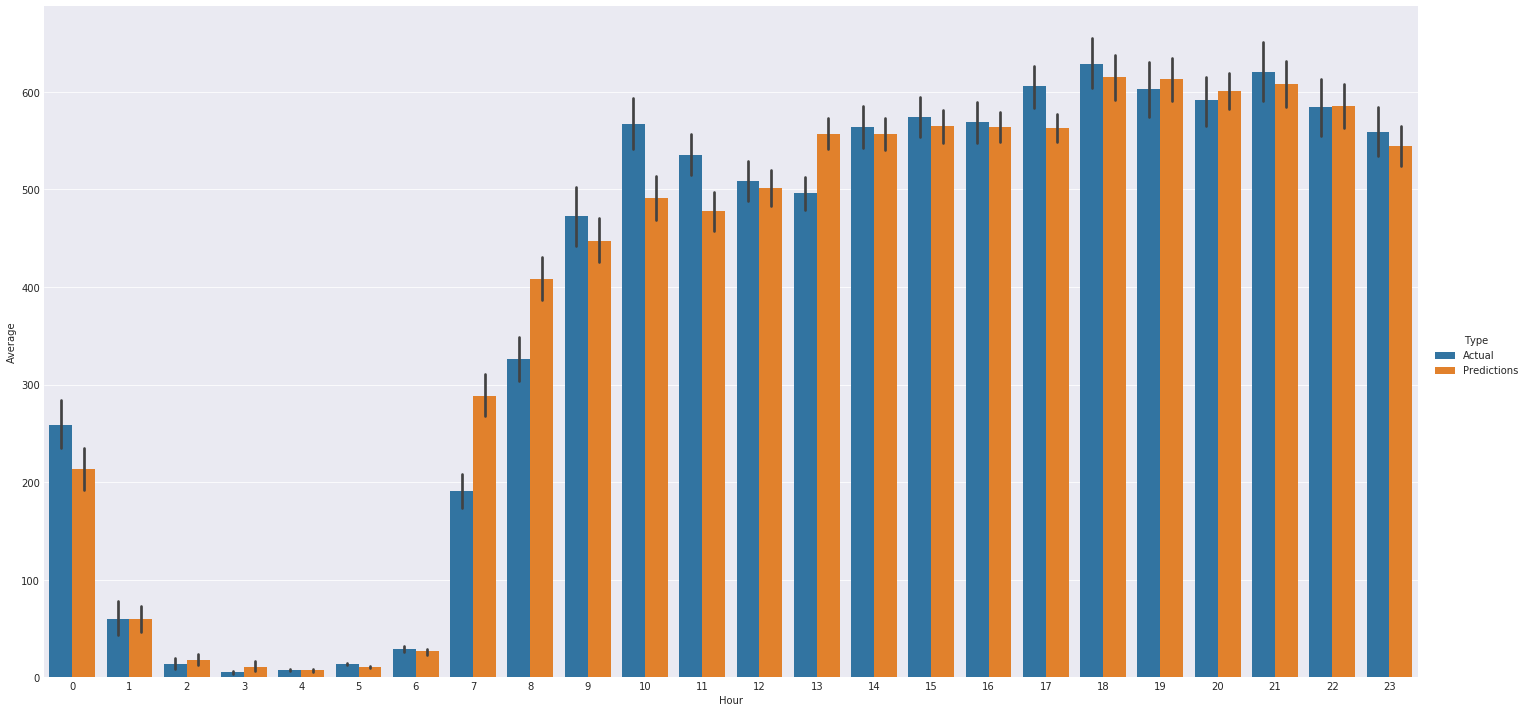

In [85]:
results_melted = pd.melt(results, id_vars="Hour", var_name="Type", value_name="Average")
sns.factorplot(x='Hour', y='Average', hue='Type', data=results_melted, kind='bar', size=10, aspect = 2)